In [1]:
import os
os.environ["LOGLEVEL"] = "PROD"

import numpy as np
import pandas as pd
from neuro_dmt.library.models.mock.circuit.test.mock_circuit_light\
    import circuit_composition, circuit_connectivity
from neuro_dmt.library.models.mock.circuit.model import MockCircuitModel

In [4]:
mock_circuit =\
    MockCircuitModel(
        circuit_composition,
        circuit_connectivity)

/home/muchu/.vmgr_repo/py38/lib/python3.8/site-packages/neuro_dmt/library/models/mock/circuit/model.py Logger
ALERT@<2020-04-06 11:11:59>                                                     
Build a Mock Circuit.
82304it [02:29, 549.58it/s]


In [3]:
circuit_model.pathway_summary.probability_connection(
    circuit_model.get_cells(mtype ="L23_MC"),
    circuit_model.get_cells(mtype="L6_TPC:A").sample(n=100))

number_pairs_total        16400.000000
number_pairs_connected      314.000000
probability_connection        0.019146
Name: 0, dtype: float64

In [30]:
circuit_model.pathway_summary.number_connections_afferent(
    circuit_model.get_cells(mtype="L23_MC"),
    circuit_model.get_cells(mtype="L6_TPC:A").sample(n=100))

number_pairs_total           mean    164.000000
                             std       0.000000
number_connections_afferent  mean      3.150000
                             std       1.424001
Name: 0, dtype: float64

In [31]:
adapter.get_connection_probability(
    circuit_model,
    pre_synaptic={"mtype": "L6_TPC:A"},
    post_synaptic={"mtype": "L6_TPC:A"},
    sample_size_pre_synaptic_cells=20,
    sample_size_post_synaptic_cells=20)

0.04

In [32]:
adapter.get_connection_probability_by_soma_distance(
    circuit_model,
    pre_synaptic={"mtype": "L6_TPC:A"},
    post_synaptic={"mtype": "L6_TPC:A"},
    sample_size_pre_synaptic_cells=20,
    sample_size_post_synaptic_cells=20)

soma_distance
50.0     0.000000
150.0    0.018349
250.0    0.030928
350.0    0.030303
450.0    0.048387
550.0    0.000000
650.0    0.000000
Name: probability_connection, dtype: float64

In [3]:
adapter.get_number_connections_afferent(
    circuit_model,
    pre_synaptic={"mtype": "L6_TPC:A"},
    post_synaptic={"mtype": "L6_TPC:A"},
    sample_size_pre_synaptic_cells=100,
    sample_size_post_synaptic_cells=100)

21.09

In [35]:
def soma_distance(
    xcell, ycell,
    bin_size=100.):
    """
    Soma distance between cells.
    Arguments
    -------------------------
    xcell / ycell : A single cell (i.e. a pandas.Series),
    ~               or a collection of cells (i.e. a pandas.DataFrame)
    """
    XYZ = ["x", "y", "z"]
    distance = np.linalg.norm(xcell[XYZ] - ycell[XYZ], axis=1)
    bin_starts = bin_size * np.floor(distance / bin_size)
    return [
        (bin_start, bin_start + bin_size)
        for bin_start in bin_starts]

In [52]:
def summary_afferent(post_cell):
    gids_afferent =\
        circuit_model.connectome.afferent_gids(
            post_cell.gid)
    return\
        circuit_model.cells.loc[
            gids_afferent
        ].assign(
            soma_distance=lambda pre_cells: soma_distance(post_cell, pre_cells),
            number_connections_afferent=1.
        )[
            pre_synaptic_cell_type_specifier + ["soma_distance", "number_connections_afferent"]
        ].groupby(
            pre_synaptic_cell_type_specifier + ["soma_distance"]
        ).agg(
            "sum"
        )

In [58]:
pre_synaptic_cell_type_specifier = ["mtype"]

post_synaptic_cell_type = {
    "mtype": "L6_TPC:A"
}
post_synaptic_cells =\
    circuit_model.get_cells(
        **post_synaptic_cell_type
    ).sample(
        n = 100
    )
number_connections_afferent =\
    pd.concat([
        summary_afferent(post_synaptic_cell)
        for _, post_synaptic_cell in post_synaptic_cells.iterrows()
    ])

In [6]:
adapter.get_afferent_connection_count_summary(
    circuit_model,
    {"mtype": "L6_TPC:A"},
    by_soma_distance=False
).head()

,number_connections_afferent
mtype,
L1_DAC,2
L1_SLAC,1
L23_ChC,1
L23_MC,2
L23_SBC,5


In [3]:
afferent_summary =\
    adapter.get_afferent_connection_count_summary(
        circuit_model,
        {"layer": 2},
        {"mtype",}
    )

In [5]:
afferent_summary.head()

(pre_synaptic, mtype)  soma_distance 
L1_DAC                 (200.0, 300.0)    1
L23_ChC                (100.0, 200.0)    1
                       (200.0, 300.0)    2
L23_MC                 (300.0, 400.0)    1
L23_SBC                (100.0, 200.0)    5
Name: number_connections_afferent, dtype: int64

In [11]:
number_connections_afferent_example =\
    adapter.get_number_connections_afferent_by_soma_distance(
        circuit_model,
        pre_synaptic={"mtype": "L6_TPC:A"},
        post_synaptic={"mtype": "L6_TPC:A"},
        sample_size_pre_synaptic_cells=100,
        sample_size_post_synaptic_cells=100)

In [8]:
from collections.abc import Mapping
from dmt.data.observation import measurement
from dmt.tk.parameters import index_tree
measurement_generator = (
    ({("post_synaptic", "mtype"): "L6_TPC:A"}, afferent_summary),
    ({("post_synaptic", "mtype"): "L6_TPC:A"}, afferent_summary)
)
def _join(parameters_measurement, value_measurement):
        """..."""
        if isinstance(parameters_measurement, Mapping):
            parameters_measurement =\
                pd.Series(
                    index_tree.as_unnested_dict(
                        parameters_measurement))
        return\
            value_measurement.rename("value")\
                             .reset_index()\
                             .apply(
                                 parameters_measurement.append,
                                 axis=1)

df = pd.concat([
    _join(*args) for args in measurement_generator
])
df.set_index([
    c for c in df.columns if c != "value"])
measurement.collection.series_type(
    measurement_generator)

value
(post_synaptic, mtype) (pre_synaptic, mtype) soma_distance          
L6_TPC:A               L1_DAC                (200.0, 300.0)        1
                       L23_ChC               (100.0, 200.0)        1
                                             (200.0, 300.0)        2
                       L23_MC                (300.0, 400.0)        1
                       L23_SBC               (100.0, 200.0)        5
                                             (200.0, 300.0)        1
                                             (300.0, 400.0)        2
                       L4_NGC                (400.0, 500.0)        1
                                             (500.0, 600.0)        2
                       L4_TPC                (300.0, 400.0)        1
                                             (400.0, 500.0)       14
                                             (500.0, 600.0)       15
                       L5_DBC                (500.0, 600.0)        1
                                             (600.0, 700.0)        1
                                             (900.0, 1000.0)       1
                                             (1000.0, 1100.0)      1
                       L5_MC                 (700.0, 800.0)        2
                                             (800.0, 900.0)        2
                                             (900.0, 1000.0)       1
                       L5_TPC:A              (500.0, 600.0)        1
                                             (600.0, 700.0)        1
                                             (700.0, 800.0)        2
                                             (800.0, 900.0)        4
                                             (900.0, 1000.0)       2
                                             (1000.0, 1100.0)      3
                       L5_TPC:B              (500.0, 600.0)        1
                                             (600.0, 700.0)        8
                                             (700.0, 800.0)        5
                                             (800.0, 900.0)        3
                                             (900.0, 1000.0)       5
...                                                              ...
                       L6_ChC                (1300.0, 1400.0)      1
                                             (1500.0, 1600.0)      1
                       L6_IPC                (900.0, 1000.0)       2
                                             (1000.0, 1100.0)      3
                                             (1100.0, 1200.0)      2
                                             (1200.0, 1300.0)      2
                                             (1300.0, 1400.0)      4
                                             (1400.0, 1500.0)      2
                                             (1600.0, 1700.0)      1
                       L6_TPC:A              (900.0, 1000.0)       1
                                             (1000.0, 1100.0)      3
                                             (1100.0, 1200.0)      5
                                             (1200.0, 1300.0)      4
                                             (1300.0, 1400.0)      2
                                             (1400.0, 1500.0)      5
                                             (1600.0, 1700.0)      2
                       L6_TPC:B              (900.0, 1000.0)       1
                                             (1000.0, 1100.0)      4
                                             (1100.0, 1200.0)      6
                                             (1200.0, 1300.0)      5
                                             (1300.0, 1400.0)      1
                                             (1400.0, 1500.0)      1
                                             (1500.0, 1600.0)      1
                                             (1600.0, 1700.0)      3
                       L6_UPC                (1000.0, 1100.0)      5
                                             (1100.0, 1200.0)

In [11]:
pre_synaptic_cells = circuit_model.get_cells(mtype="L23_MC")
post_synaptic_cells = circuit_model.get_cells(mtype="L23_MC").sample(n=100)

In [25]:
number_connections_afferent_example

soma_distance
50.0     1.510000
150.0    5.570000
250.0    5.990000
350.0    3.460000
450.0    2.557895
550.0    2.000000
650.0    1.148148
Name: mean, dtype: float64

In [4]:
from dmt.tk.parameters import Parameters
from neuro_dmt.models.bluebrain.circuit.adapter import\
    BlueBrainCircuitAdapter

parameters_pathways_with_soma_distance = Parameters(
    circuit_model.pathways(
        {"mtype",}
    ).assign(
        upper_bound_soma_distance=500.
    ))
adapter = BlueBrainCircuitAdapter()
parameters_for_sampling =\
    parameters_pathways_with_soma_distance.for_sampling(size=10)
adapter.get_connection_probability(
    circuit_model,
    **parameters_for_sampling[0])

('region', 'layer', 'depth', 'height', 'mesocolumn', 'hypercolumn', 'mtype', 'etype', 'synapse_class', 'postsynaptic', 'presynaptic')


dummy_variable
0    0.02102
Name: connection_probability, dtype: float64

In [5]:
parameters_pathways_with_soma_distance = Parameters(
    circuit_model.pathways(
        {"mtype",}
    ).assign(
        upper_bound_soma_distance=50.
    ))
adapter = BlueBrainCircuitAdapter()
parameters_for_sampling =\
    parameters_pathways_with_soma_distance.for_sampling(size=10)
adapter.get_connection_probability(
    circuit_model,
    **parameters_for_sampling[0])

dummy_variable
0    0.029801
Name: connection_probability, dtype: float64

In [6]:
from neuro_dmt.models.bluebrain.circuit.model.pathway import\
    ConnectionProbabilityBySomaDistance
conn_prob_sd = ConnectionProbabilityBySomaDistance(circuit_model=circuit_model)

In [2]:
from neuro_dmt.models.bluebrain.circuit.test.test_connectome_analysis import *
phenomenon = Phenomenon(
    "Connection Probability",
    """
    Probability that two neurons in a pathway are connected.
    While mostly interested in `mtype->mtype` pathways, we can define
    a pathway as the group of connected neurons with pre-synaptic and
    post-synaptic neurons belonging to two parametrically defined groups.
    As an example consider neuron populations defined by not only `mtype`
    but also by soma-distance from a given location.
    """,
    group="Connectome")
number_pathways = 5
pathways =\
    mock_circuit_model.pathways(frozenset(("mtype",)))\
        .sample(n=number_pathways)

('region', 'layer', 'depth', 'height', 'mesocolumn', 'hypercolumn', 'mtype', 'etype', 'synapse_class', 'postsynaptic', 'presynaptic')
('region', 'layer', 'depth', 'height', 'mesocolumn', 'hypercolumn', 'mtype', 'etype', 'synapse_class', 'postsynaptic', 'presynaptic')
('region', 'layer', 'depth', 'height', 'mesocolumn', 'hypercolumn', 'mtype', 'etype', 'synapse_class', 'postsynaptic', 'presynaptic')
('region', 'layer', 'depth', 'height', 'mtype', 'etype', 'synapse_class')
('region', 'layer', 'depth', 'height', 'mtype', 'etype', 'synapse_class')
('region', 'layer', 'depth', 'height', 'mesocolumn', 'hypercolumn', 'mtype', 'etype', 'synapse_class', 'postsynaptic', 'presynaptic')


In [3]:
from collections import OrderedDict
from dmt.data.observation import measurement
from neuro_dmt.models.bluebrain.circuit.adapter import BlueBrainCircuitAdapter

adapter =\
    BlueBrainCircuitAdapter()

cell_types=pd.DataFrame([
    OrderedDict({"mtype": "L23_MC"}),
    OrderedDict({"mtype": "L6_TPC:A"}), 
    OrderedDict({"mtype": "L5_TPC:A"}),
    OrderedDict({"mtype": "L5_MC"}),
    OrderedDict({"mtype": "L6_ChC"})])
pathways =\
    adapter.get_pathways(
        mock_circuit_model,
        cell_group=cell_types)
analysis_test = BlueBrainCircuitAnalysisTest(
    analysis=BrainCircuitAnalysis(
    phenomenon=phenomenon,
    AdapterInterface=ConnectionProbabilityBySomaDistanceInterface,
    measurement_parameters=Parameters(pathways),
    measurement_collection=measurement.collection.series_type,
    plotter=HeatMap(
        xvar=("pre_synaptic", "mtype"),
        xlabel="pre-mtype",
        yvar=("post_synaptic", "mtype"),
        ylabel="post-mtype",
        vvar=("connection_probability", "mean"))))
analysis =\
    analysis_test._circuit_analysis_test.analysis

In [26]:
connection_probability_measurement =\
    analysis_test.test_get_measurement(
        mock_circuit_model,
        sample_size=10,
        sample_size_pre_synaptic_cells=10,
        sample_size_post_synaptic_cells=10)
cpm =\
    connection_probability_measurement[
    "BlueBrainCircuitModelMockLight"]

In [3]:
phenomenon = Phenomenon(
        "Afferent Connection Count",
        """
        Number of afferent connections incident at a post-synaptic cell.
        While mostly interested in `mtype->mtype` pathways, we can define
        a pathway as the group of connected neurons with pre-synaptic and
        post-synaptic neurons belonging to two parametrically defined groups.
        As an example consider neuron populations defined by not only `mtype`
        but also by soma-distance from a given location.
        """,
        group="Connectome")
post_synaptic_cell_types =\
    pd.DataFrame({
        ("post_synaptic", "mtype"): [
        "L23_MC", "L6_TPC:A", "L5_TPC:A", "L5_MC", "L6_ChC"]
    })
analysis_test = BlueBrainCircuitAnalysisTest(
    analysis=BrainCircuitAnalysis(
    phenomenon=phenomenon,
    AdapterInterface=AfferentConnectionCountInterface,
    measurement_parameters=Parameters(post_synaptic_cell_types),
    measurement_collection=measurement.collection.series_type,
    plotter=LinePlot(
        xvar="soma_distance",
        xlabel="Soma Distance",
        yvar="afferent_connection_count",
        ylabel="Mean number of afferent connections",
        gvar=("pre_synaptic", "mtype"),
        fvar=("post_synaptic", "mtype"),
        drawstyle="steps-mid")))
analysis =\
    analysis_test._circuit_analysis_test.analysis

In [4]:
aff_conn_measurement =\
    analysis_test.test_get_measurement(
        mock_circuit_model,
        sample_size=2
    )

In [6]:

measurement.concat_as_samples(aff_conn_measurement).reset_index().head()

,dataset,"(post_synaptic, mtype)","(pre_synaptic, mtype)",soma_distance,afferent_connection_count
0,BlueBrainCircuitModelMockLight,L23_MC,L1_DAC,250.0,1
1,BlueBrainCircuitModelMockLight,L23_MC,L1_DAC,350.0,1
2,BlueBrainCircuitModelMockLight,L23_MC,L1_SLAC,250.0,1
3,BlueBrainCircuitModelMockLight,L23_MC,L23_ChC,150.0,1
4,BlueBrainCircuitModelMockLight,L23_MC,L23_ChC,250.0,2


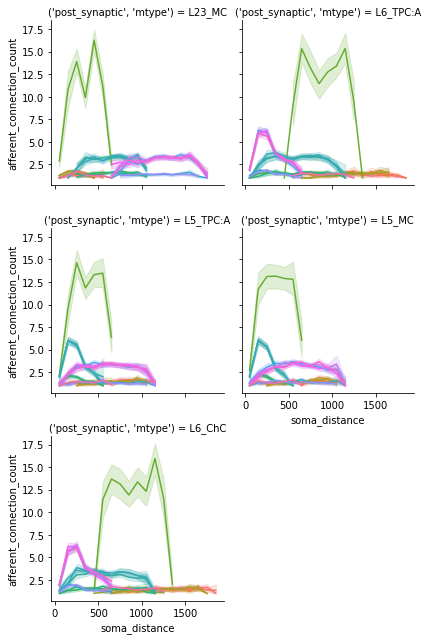

In [7]:
import seaborn
from dmt.data.observation import measurement
pdf = measurement.concat_as_samples(aff_conn_measurement).reset_index()

grid = seaborn.FacetGrid(
    pdf,
    col=("post_synaptic", "mtype"),
    hue=("pre_synaptic", "mtype"),
    col_wrap=2,
    legend_out=True
)
grid.map(
    seaborn.lineplot,
    "soma_distance",
    "afferent_connection_count")

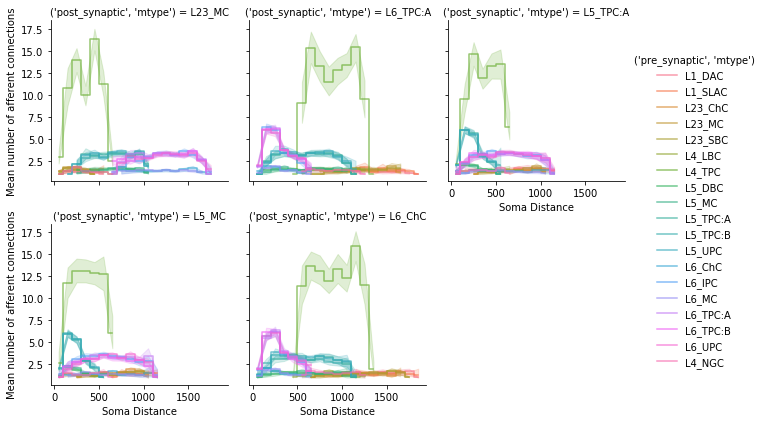

In [8]:
analysis.plotter.get_figure(aff_conn_measurement)

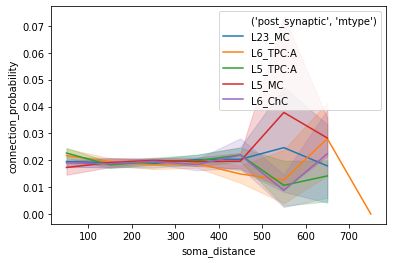

In [13]:
import seaborn; seaborn.set
axes = seaborn.lineplot(
    y="connection_probability",
    x="soma_distance",
    hue=("post_synaptic", "mtype"),
    data=cpm.reset_index())

Prototype step plots for afferent summary

In [35]:
number_connections_afferent_example.apply(
    lambda x: x + 1.e-1 * np.random.uniform())

soma_distance
50.0     1.325122
150.0    5.354592
250.0    6.714841
350.0    3.897374
450.0    2.253296
550.0    2.048119
650.0    0.777520
Name: mean, dtype: float64

In [41]:
def get_mock_afferent_connections(
    pre_synaptic_mtype,
    post_synaptic_mtype):
    """..."""
    return pd.concat(
        20 * [
            number_connections_afferent_example.apply(
                lambda x: x + 1.e0 * np.random.uniform()
            ).rename(
                "number_connections_afferent"
            ).reset_index(
            ).assign(
                pre_synaptic_mtype=pre_synaptic_mtype,
                post_synaptic_mtype=post_synaptic_mtype
            ).set_index(
                ["pre_synaptic_mtype", "post_synaptic_mtype", "soma_distance"]
            )]
    )

get_mock_afferent_connections("L23_MC", "L6_TPC:A").head()

number_connections_afferent
pre_synaptic_mtype post_synaptic_mtype soma_distance                             
L23_MC             L6_TPC:A            50.0                              1.520382
                                       150.0                             5.404062
                                       250.0                             6.987552
                                       350.0                             4.242313
                                       450.0                             3.063308

In [42]:
mock_afferent_connections =\
    pd.concat([
        get_mock_afferent_connections("L23_MC", "L23_MC"),
        get_mock_afferent_connections("L23_MC", "L6_TPC:A"),
        get_mock_afferent_connections("L6_TPC:A", "L23_MC"),
        get_mock_afferent_connections("L6_TPC:A", "L6_TPC:A")
    ])

In [43]:
mock_afferent_connections.head()

number_connections_afferent
pre_synaptic_mtype post_synaptic_mtype soma_distance                             
L23_MC             L23_MC              50.0                              1.707334
                                       150.0                             5.807221
                                       250.0                             6.957812
                                       350.0                             3.975112
                                       450.0                             3.196165

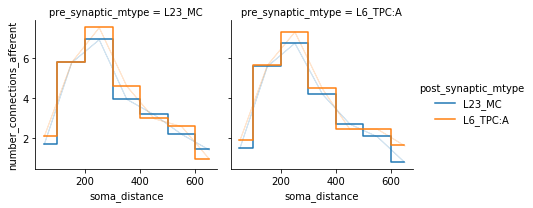

In [44]:
import matplotlib.pyplot as plt
import seaborn

graphic =\
    seaborn.FacetGrid(
        mock_afferent_connections.reset_index(),
        col="pre_synaptic_mtype",
        hue="post_synaptic_mtype"
)
graphic.map(
    seaborn.lineplot,
    "soma_distance",
    "number_connections_afferent",
    drawstyle="steps-mid"
)
graphic.add_legend()

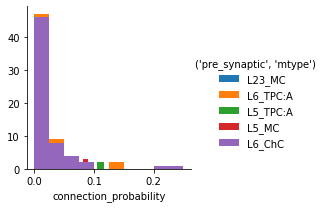

In [9]:
import matplotlib.pylplot as plt
graphic =\
    seaborn.FacetGrid(
        cpm.reset_index(),
        col=None,#"post_synaptic_mtype",
        hue=("pre_synaptic", "mtype"))
graphic.map(plt.hist, "connection_probability")
graphic.add_legend()

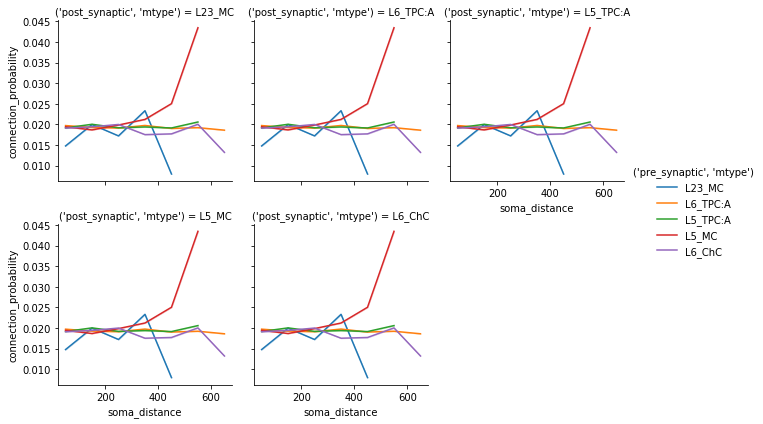

In [9]:
graphic =\
    seaborn.FacetGrid(
        cpm.reset_index(),
        hue=("pre_synaptic", "mtype"),
        col=("post_synaptic", "mtype"),
        col_wrap=3, height=3.0)
graphic.map(
    seaborn.lineplot,
    "soma_distance",
    "connection_probability")
graphic.add_legend()

In [10]:
from dmt.tk.plotting.lines import LinePlot
line_plot = LinePlot(
    xvar="soma_distance",
    xlabel="Soma Distance",
    yvar="connection_probability",
    ylabel="Connection Probability",
    gvar=("pre_synaptic", "mtype"),
    fvar=("post_synaptic", "mtype"))

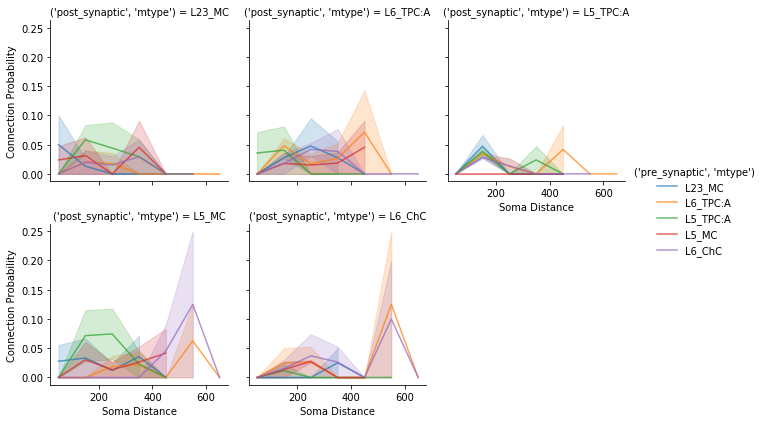

In [11]:
line_plot.get_figure(connection_probability_measurement)

In [19]:
cpm.loc[("L23_MC", "L23_MC")]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


,connection_probability
soma_distance,
50.0,0.014784
150.0,0.019979
250.0,0.017224
350.0,0.023333
450.0,0.007979
50.0,0.014784
150.0,0.019979
250.0,0.017224
350.0,0.023333


In [5]:
adapter.get_connection_probability_by_soma_distance(
    circuit_model=mock_circuit_model,
    pre_synaptic={"mtype": "L23_MC"},
    post_synaptic={"mtype": "L23_MC"},
    sample_size_post_synaptic_cells=100,
    sample_size_pre_synaptic_cells=100)

soma_distance
50.0     0.022241
150.0    0.017052
250.0    0.021307
350.0    0.014745
450.0    0.028986
Name: probability_connection, dtype: float64

In [6]:
adapter.get_connection_probability_by_soma_distance(
    circuit_model=mock_circuit_model,
    pre_synaptic={"mtype": "L23_MC"},
    post_synaptic={"mtype": "L23_MC"},
    sample_size_post_synaptic_cells=100,
    sample_size_pre_synaptic_cells=100)

soma_distance
50.0     0.019983
150.0    0.017115
250.0    0.023979
350.0    0.015212
450.0    0.013072
Name: probability_connection, dtype: float64